In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns


## Data Preparation

In [2]:
# Training data sets
train_beneficiarydata = pd.read_csv("./healthCareData/train_beneficiarydata.csv")
train_inpatientdata = pd.read_csv("./healthCareData/train_inpatientdata.csv")
train_outpatientdata = pd.read_csv("./healthCareData/train_outpatientdata.csv")
train_potentialfraud = pd.read_csv("./healthCareData/train_potentialfraud.csv")

#Testing data sets
test_beneficiarydata = pd.read_csv("./healthCareData/test_beneficiarydata.csv")
test_inpatientdata = pd.read_csv("./healthCareData/test_inpatientdata.csv")
test_outpatientdata = pd.read_csv("./healthCareData/test_outpatientdata.csv")
test_potentialfraud = pd.read_csv("./healthCareData/test_potentialfraud.csv")


In [3]:
pd.options.display.max_columns = None


In [4]:
#How many medical doctors are there in the train outpatient dataset?
train_outpatientdata.AttendingPhysician.unique().shape  # there are 74,110 attending physicians

#How many medical doctors are there in the train inpatient dataset? Do they match with those from the outpatient record?
train_inpatientdata.AttendingPhysician.unique().shape  # there are 11,605 attending phsyicians. There are more providers on the outpatient data

(11605,)

In [5]:
#Create columns for inpatient and outpatient data.
train_inpatientdata['patientType'] = np.repeat('inpatient', len(train_inpatientdata))
train_outpatientdata['patientType'] = np.repeat('outpatient', len(train_outpatientdata))



In [6]:
#Combining the inpatient and outpatient data
patient = pd.concat([train_inpatientdata, train_outpatientdata], axis=0)
patient.BeneID.unique().shape

(138556,)

In [7]:
#Merge the patient data frame and 
full_data =pd.merge(patient, train_beneficiarydata, on='BeneID', how='left')

In [23]:
full_data= pd.merge(full_data, train_potentialfraud, on='Provider', how='left')

# Exploratory Data Analysis

## Doctors and Providers

### How many medical doctors are there in the train outpatient dataset? How many medical doctors are there in the train inpatient dataset? Do they match with those from the outpatient record?

- There are 11,605 doctors in the inpatient data and 74,110 doctors in the outpatient data.

### Do those inpatient patients show worse health conditions (in terms of chronic diseases) than typical outpatient patients?

In [8]:
print(full_data.loc[full_data.patientType=='inpatient'].AttendingPhysician.unique().shape[0])
print(full_data.loc[full_data.patientType=='outpatient'].AttendingPhysician.unique().shape[0])


11605
74110


### Do doctors serve for different providers? Study the distribution of hospital counts/doctor? Is it possible to characterize those doctors who move around among different providers?

- Most doctors have a connection of 1 clinic. 

In [9]:
physician= full_data.groupby(['AttendingPhysician','Provider'])['Provider'].count().\
reset_index(name='NumProvider').groupby(['AttendingPhysician'])['NumProvider'].count().reset_index()

print(physician.NumProvider.value_counts())


1    76844
2     4741
3      382
4       65
5       19
6        9
9        1
8        1
7        1
Name: NumProvider, dtype: int64


In [10]:
phy3 = physician.loc[physician.NumProvider==9]

phy4 = pd.concat([phy3, full_data[['AttendingPhysician', 'Provider']]], axis=1)
phy5 = pd.merge(phy4, train_potentialfraud, on='Provider', how='left')


Text(0, 0.5, 'number of doctors per provider')

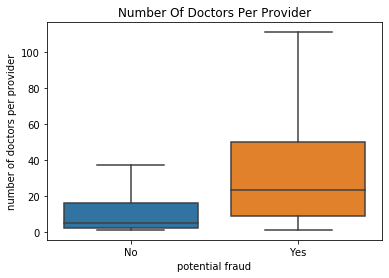

In [11]:
doctors = full_data.groupby(['Provider', 'AttendingPhysician'])['AttendingPhysician'].count().reset_index(name='NumOfDoctors').\
groupby('Provider')['NumOfDoctors'].count().reset_index()

doctors2 = pd.merge(doctors, train_potentialfraud, on='Provider', how='left')


sns.boxplot(x='PotentialFraud', y='NumOfDoctors', data=doctors2, showfliers=False)
plt.title('Number Of Doctors Per Provider')
plt.xlabel('potential fraud')
plt.ylabel('number of doctors per provider')

## Feature Engineering

- add number of doctors

In [12]:
doctors= full_data.groupby(['Provider', 'AttendingPhysician'])['AttendingPhysician'].count().\
reset_index(name='NumOfDoctors').groupby('Provider')['NumOfDoctors'].count().reset_index()

trainProvider = pd.merge(train_potentialfraud, doctors, on='Provider')
trainProvider.sample(2)


,Provider,PotentialFraud,NumOfDoctors
1597,PRV52986,No,18
1864,PRV53326,No,5


## Providers and Patients

### How many distinct patients (BeneIDs) are there in the in/out-patient datasets?
- There are 31,289 inpatient patients and 133,980 outpatient patients

In [19]:
print(full_data.loc[full_data.patientType=='inpatient'].BeneID.unique().shape[0])
print(full_data.loc[full_data.patientType=='outpatient'].BeneID.unique().shape[0])


31289
133980


### Do patients go to different hospitals? Study the distribution of hospital counts/patient? It is possible to characterize those patients who receive services from a lot of different hospitals?¶
We can characterize these patients by the number of providers they have. We can generate a new feature providers per patient.

In [24]:
patient= full_data.groupby(['BeneID', 'Provider', 'PotentialFraud'])['BeneID'].count().reset_index(name='NumProvider').\
groupby(['BeneID', 'PotentialFraud'])['NumProvider'].count().reset_index()


Text(0.5, 1.0, 'Proportion of Providers Per Patient')

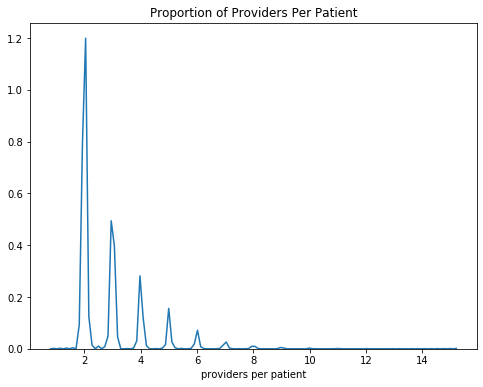

In [25]:
plt.subplots(figsize=(8,6))
sns.distplot(patient['NumProvider'], hist=False)
plt.xlabel('providers per patient')
plt.title('Proportion of Providers Per Patient')

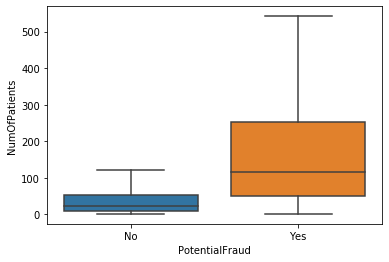

In [26]:
patients = full_data.groupby(['Provider', 'BeneID'])['BeneID'].count().reset_index(name='NumOfPatients').\
groupby('Provider')['NumOfPatients'].count().reset_index()

provider_patient= pd.merge(patients, train_potentialfraud, on='Provider', how='left')

sns.boxplot(x='PotentialFraud', y='NumOfPatients', data=provider_patient, showfliers=False)


## Feature Engineering
- add number of patients

In [27]:
patient= full_data.groupby(['Provider','BeneID'])['BeneID'].count().reset_index(name='NumOfPatients').\
groupby('Provider')['NumOfPatients'].count().reset_index()

trainProvider2 = pd.merge(trainProvider, patient, on='Provider', how='left')
trainProvider2.sample(2)

,Provider,PotentialFraud,NumOfDoctors,NumOfPatients
959,PRV52197,No,4,10
1413,PRV52754,No,1,1


In [28]:
patient= full_data.groupby(['Provider','BeneID'])['BeneID'].count().reset_index(name='NumOfPatients').\
groupby('Provider')['NumOfPatients'].count().reset_index()

trainProvider = pd.merge(patient, train_potentialfraud, on='Provider')
trainProvider.sample(2)

,Provider,NumOfPatients,PotentialFraud
584,PRV51732,12,No
1258,PRV52564,21,No


## How  does providers' number of doctors and patients help detect fraud?

Text(0, 0.5, 'number of patients')

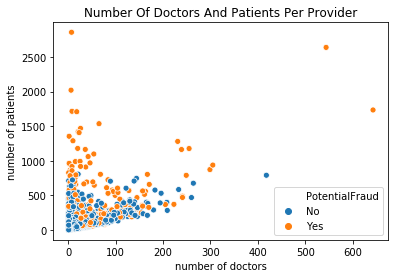

In [29]:
sns.scatterplot(x='NumOfDoctors', y='NumOfPatients', data=trainProvider2, hue='PotentialFraud')
plt.title('Number Of Doctors And Patients Per Provider')
plt.xlabel('number of doctors')
plt.ylabel('number of patients')

## Providers and Type of service

## Do the same providers provide both inpatient and outpatient services? Summarize your finding.

- There are 1694 providers that offer both services
- There are 398 providers that offer inpatient services only
- There are 3318 providers thar offer outpatient services only

In [30]:
a = full_data.groupby(['Provider', 'patientType'])['BeneID'].count().reset_index(name='count').\
drop('count', axis=1)

a_list= list(zip(a.Provider, a.patientType))

providerDict= {}

for ele in a_list:
    if ele[0] not in providerDict:
        providerDict[ele[0]]= ele[1]    
    else:
        providerDict[ele[0]] = 'both'
        

providerService = pd.DataFrame(providerDict.keys(), providerDict.values()).reset_index().\
rename(columns={'index':'ServiceType', 0:'Provider'})


In [16]:
serviceFraud = pd.merge(train_potentialfraud, providerService, on='Provider')

serviceFraud.groupby('ServiceType')['Provider'].count()

ServiceType
both          1694
inpatient      398
outpatient    3318
Name: Provider, dtype: int64

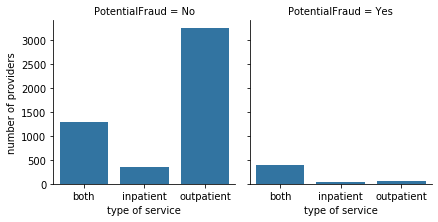

In [18]:
serviceFraud = pd.merge(train_potentialfraud, providerService, on='Provider')

service = serviceFraud.groupby(['ServiceType', 'PotentialFraud'])['Provider'].count().reset_index(name='count')


g = sns.FacetGrid(service, col="PotentialFraud")
g.map_dataframe(sns.barplot, x="ServiceType", y="count")
g.set_axis_labels("type of service", "number of providers")


## Feature engineering
- add type of service

In [32]:
trainProvider3 = pd.merge(trainProvider2, providerService, on='Provider')
trainProvider3.sample(2)

,Provider,PotentialFraud,NumOfDoctors,NumOfPatients,ServiceType
1395,PRV52732,No,1,6,outpatient
1506,PRV52865,No,23,57,both
